In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import MDAnalysis as mda
from MDAnalysis.analysis import rms

from sklearn.cluster import AgglomerativeClustering

from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

In [2]:
run = 'md-6WTT-1'
tpr = f'../../trajectories/{run}/{run}.tpr'
xtc = f'../../trajectories/{run}/{run}.xtc'

u = mda.Universe(tpr, xtc)
n_frames = len(u.trajectory)

/Users/musso/cbp_project/8DD9/.venv/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:215: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [3]:
siteA = 'resnum 41  49  135 142 144 163 to 166 172 189 192'
siteB = 'resnum 347 355 441 448 450 469 to 472 478 495 498'

ligA = "resid 613"
ligB = "resid 614"

In [4]:
ligA_sel = u.select_atoms(ligA)
ligB_sel = u.select_atoms(ligB)

siteA_sel = u.select_atoms(siteA)
siteB_sel = u.select_atoms(siteB)

In [5]:
rgyr_ligA = np.zeros(n_frames)
rgyr_ligB = np.zeros(n_frames)

dis_ligA = np.zeros(n_frames)
dis_ligB = np.zeros(n_frames)

for ts in u.trajectory:
    i = ts.frame
    
    rgyr_ligA[i] = ligA_sel.radius_of_gyration()
    rgyr_ligB[i] = ligB_sel.radius_of_gyration()
    
    dis_ligA[i] = np.linalg.norm(siteA_sel.center_of_mass() - ligA_sel.center_of_mass())
    dis_ligB[i] = np.linalg.norm(siteB_sel.center_of_mass() - ligB_sel.center_of_mass())

In [6]:
XA = np.vstack((rgyr_ligA, dis_ligA)).T
XB = np.vstack((rgyr_ligB, dis_ligB)).T

labelA = AgglomerativeClustering(n_clusters=2, linkage='ward').fit_predict(XA)
labelB = AgglomerativeClustering(n_clusters=2, linkage='ward').fit_predict(XB)

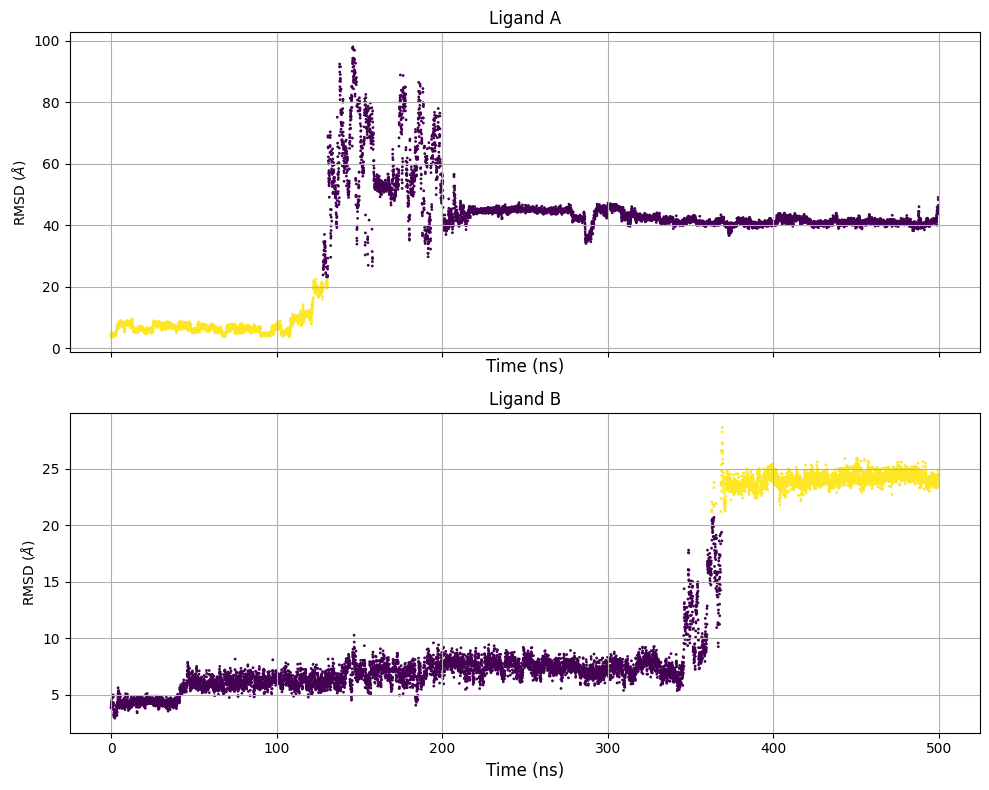

In [7]:
times = np.arange(n_frames) * 0.05 # ns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.scatter(times, dis_ligA, c=labelA, s=1)
ax1.set(ylabel ='RMSD ($\AA$)', title ='Ligand A')
ax1.set_xlabel('Time (ns)', fontsize=12)
ax1.grid()

ax2.scatter(times, dis_ligB, c=labelB, s=1)
ax2.set(ylabel ='RMSD ($\AA$)', title ='Ligand B')
ax2.set_xlabel('Time (ns)', fontsize=12)
ax2.grid()

plt.tight_layout();

In [8]:
hbA = HydrogenBondAnalysis(
    universe=u,
    between=[[siteA, ligA]],
    update_selections=False
)

hbA.run(verbose=True)

  0%|          | 0/10001 [00:00<?, ?it/s]

In [9]:
hbB = HydrogenBondAnalysis(
    universe=u,
    between=[[siteB, ligB]],
    update_selections=False
)

hbB.run(verbose=True)

  0%|          | 0/10001 [00:00<?, ?it/s]

In [10]:
columns = ['frame', 'donor_index', 'hydrogen_index', 'acceptor_index', 'DA_distance', 'DHA_angle']
hbA_df = pd.DataFrame(hbA.results.hbonds.copy(), columns=columns)
hbB_df = pd.DataFrame(hbB.results.hbonds.copy(), columns=columns)

hbA_df.to_csv('hbA_wt.csv', index=False)
hbB_df.to_csv('hbB_wt.csv', index=False)

In [11]:
window = 200
stride = 50

countsA = hbA.count_by_time()
countsB = hbB.count_by_time()

edgesA = np.arange(0, len(countsA)-window+stride, stride) # bin edges
edgesB = np.arange(0, len(countsB)-window+stride, stride) # bin edges

countsA_byT = np.zeros(len(edgesA))
for i, edge in enumerate(edgesA):
    countsA_byT[i] = np.sum(countsA[edge:edge+window]) / window
    
countsB_byT = np.zeros(len(edgesB))
for i, edge in enumerate(edgesB):
    countsB_byT[i] = np.sum(countsB[edge:edge+window]) / window

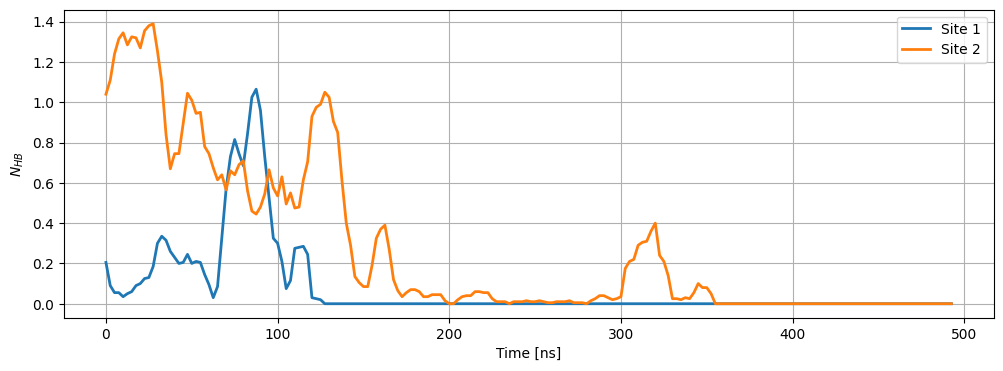

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), sharey=True)

ax.plot(edgesA * 50 / 1000 + hbA.times[0] / 1000, countsA_byT, lw=2, label='Site 1')
ax.plot(edgesB * 50 / 1000 + hbB.times[0] / 1000, countsB_byT, lw=2, label='Site 2')
ax.set_xlabel("Time [ns]")
ax.set_ylabel(r"$N_{HB}$")
ax.grid()
ax.legend()

plt.savefig('../results/run_wt/hb_time.pdf', bbox_inches='tight')

plt.show()

In [13]:
map_siteA = {}
for i, j in zip(siteA_sel.indices, siteA_sel.resids):
    map_siteA[i] = j
    
map_siteB = {}
for i, j in zip(siteB_sel.indices, siteB_sel.resids):
    map_siteB[i] = j - 306

In [14]:
hbA_byIds = hbA.count_by_ids().copy()[:, [0, 2, 3]]
hbB_byIds = hbB.count_by_ids().copy()[:, [0, 2, 3]]

for i, bond in enumerate(hbA_byIds):
    if bond[0] > 9364:
        hbA_byIds[i][:2] = (bond[1], bond[0])
        
for i, bond in enumerate(hbB_byIds):
    if bond[0] > 9364:
        hbB_byIds[i][:2] = (bond[1], bond[0])
        
hbA_byIds = hbA_byIds[hbA_byIds[:, 0].argsort()]
hbB_byIds = hbB_byIds[hbB_byIds[:, 0].argsort()]

hbA_byIds[-3][2] = hbA_byIds[-3][2] + hbA_byIds[-2][2]
hbA_byIds = np.delete(hbA_byIds, (-2), axis=0)

hbB_byIds[-3][2] = hbB_byIds[-3][2] + hbB_byIds[-2][2]
hbB_byIds = np.delete(hbB_byIds, (-2), axis=0)

for bond in hbA_byIds:
    bond[0] = map_siteA[bond[0]]
    
for bond in hbB_byIds:
    bond[0] = map_siteB[bond[0]]
    
bondsA = []
for res in np.unique(hbA_byIds[:, 0]):
    res_bonds = hbA_byIds[np.where(hbA_byIds[:, 0] == res)]
    for atom in np.unique(res_bonds[:, 1]):
        bondsA.append([res, atom, np.sum(res_bonds[np.where(res_bonds[:, 1] == atom)][:, 2])])
        
bondsB = []
for res in np.unique(hbB_byIds[:, 0]):
    res_bonds = hbB_byIds[np.where(hbB_byIds[:, 0] == res)]
    for atom in np.unique(res_bonds[:, 1]):
        bondsB.append([res, atom, np.sum(res_bonds[np.where(res_bonds[:, 1] == atom)][:, 2])])
        
bondsA = np.array(bondsA)
bondsB = np.array(bondsB)

bondsA = bondsA[bondsA[:, 1].argsort()] 
bondsB = bondsB[bondsB[:, 1].argsort()]

bondsA[:, 1] = bondsA[:, 1] - 9363
bondsB[:, 1] = bondsB[:, 1] - 9423

/Users/musso/cbp_project/8DD9/.venv/lib/python3.8/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:662: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [15]:
nframesA = 125 * 20
nframesB = 360 * 20

In [16]:
siteA_bonds = np.zeros((np.unique(bondsA[:, 0]).shape[0], 2))
siteB_bonds = np.zeros((np.unique(bondsB[:, 0]).shape[0], 2))

for i, res in enumerate(np.unique(bondsA[:, 0])):
    siteA_bonds[i] = (res, np.sum(bondsA[np.where(bondsA[:, 0] == res)][:, 2]))
    
for i, res in enumerate(np.unique(bondsB[:, 0])):
    siteB_bonds[i] = (res, np.sum(bondsB[np.where(bondsB[:, 0] == res)][:, 2]))
    
siteA_bonds[:, 1] = siteA_bonds[:, 1] / nframesA
siteB_bonds[:, 1] = siteB_bonds[:, 1] / nframesB

In [17]:
ligA_bonds = np.zeros((np.unique(bondsA[:, 1]).shape[0], 2))
ligB_bonds = np.zeros((np.unique(bondsB[:, 1]).shape[0], 2))

for i, atom in enumerate(np.unique(bondsA[:, 1])):
    ligA_bonds[i] = (atom, np.sum(bondsA[np.where(bondsA[:, 1] == atom)][:, 2]))
    
for i, atom in enumerate(np.unique(bondsB[:, 1])):
    ligB_bonds[i] = (atom, np.sum(bondsB[np.where(bondsB[:, 1] == atom)][:, 2]))
    

ligA_bonds[:, 1] = ligA_bonds[:, 1] / nframesA
ligB_bonds[:, 1] = ligB_bonds[:, 1] / nframesB

In [18]:
site = ['41', '49', '135', '142', '144', '163', '164', '165', '166', '172', '189', '192']

siteA_Bonds = []
siteB_Bonds = []

for res in site:
    if res in siteA_bonds[:, 0].astype(int).astype(str):
        siteA_Bonds.append(siteA_bonds[np.where(siteA_bonds[:, 0].astype(int).astype(str) == res)[0], 1][0])
    else: siteA_Bonds.append(0)
        
    if res in siteB_bonds[:, 0].astype(int).astype(str):
        siteB_Bonds.append(siteB_bonds[np.where(siteB_bonds[:, 0].astype(int).astype(str) == res)[0], 1][0])
    else: siteB_Bonds.append(0)

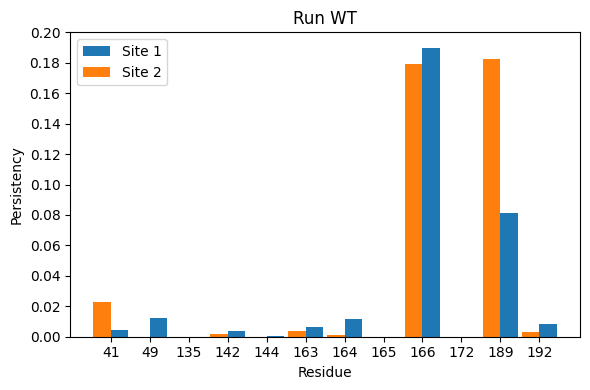

In [20]:
fig, ax = plt.subplots(figsize=(6, 4), sharey=True)

x = np.arange(12)

ax.bar(x + 0.225, siteA_Bonds, 0.45, label='Site 1')
ax.bar(x - 0.225, siteB_Bonds, 0.45, label='Site 2')
ax.set(ylabel='Persistency', xlabel='Residue', title='Run WT')
ax.set_xticks(x)
ax.set_xticklabels(site)
ax.legend()
# ax.set_ylim([0, 0.20])
ax.set_yticks(np.linspace(0, 0.2, 11))

plt.savefig('../results/run_wt/hb_perc.pdf', bbox_inches='tight')

plt.tight_layout();